# Basic RAG with LangGraph

This notebook demonstrates how to build a simple Retrieval-Augmented Generation (RAG) system using LangGraph.

## What is RAG?

RAG combines the power of information retrieval with large language models:
1. **Retrieve**: Find relevant documents from a knowledge base
2. **Generate**: Use those documents as context to generate accurate answers

## Learning Objectives

By the end of this notebook, you will:
- Understand the basic RAG workflow
- Connect to a pre-existing ChromaDB vector store
- Build a simple LangGraph with retrieve and generate nodes
- Query your RAG system with real questions

## Setup and Imports

First, let's import all the necessary libraries for our RAG system.

In [1]:
import os
from pathlib import Path
from typing import List, TypedDict

from dotenv import load_dotenv
from langchain_chroma import Chroma
from langchain_core.documents import Document
from langchain_core.prompts import ChatPromptTemplate
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langgraph.graph import StateGraph
from IPython.display import Image, display

# Load environment variables
load_dotenv()

print("All imports successful!")

All imports successful!


## Environment Setup

Make sure you have your OpenAI API key set up in your environment variables.

In [2]:
# Check if OpenAI API key is available
openai_api_key = os.getenv("OPENAI_API_KEY")
if not openai_api_key:
    raise ValueError("OPENAI_API_KEY environment variable is required")

print("OpenAI API key found!")

OpenAI API key found!


## Connect to ChromaDB Vector Store

We'll connect to the pre-existing ChromaDB vector store that contains our TechMart data (product catalog, FAQ, and troubleshooting information).

In [3]:
# Initialize embeddings model (same as used during ingestion)
embeddings = OpenAIEmbeddings(
    model=os.getenv("OPENAI_EMBEDDING_MODEL", "text-embedding-3-small"),
    api_key=openai_api_key
)

# Connect to the existing ChromaDB vector store
chroma_db_path = Path("..") / "vector_store" / "chroma_db_single"

# check if path exists
if not chroma_db_path.exists():
    raise FileNotFoundError(f"ChromaDB path does not exist: {chroma_db_path}")

vector_store = Chroma(
    collection_name="techmart_data",
    embedding_function=embeddings,
    persist_directory=str(chroma_db_path)
)

print(f"Connected to ChromaDB at: {chroma_db_path}")
print(f"Collection contains {vector_store._collection.count()} documents")

Connected to ChromaDB at: ../vector_store/chroma_db_single
Collection contains 529 documents


## Test the Vector Store

Let's do a quick test to make sure our vector store is working correctly.

In [8]:
# Test the vector store with a simple query
test_query = "when will my order be delivered?"
test_results = vector_store.similarity_search(test_query, k=3)

print(f"Test query: '{test_query}'")
print(f"Found {len(test_results)} relevant documents")
print()

for i, doc in enumerate(test_results, 1):
    print(f"Document {i}:")
    print(f"Source: {doc.metadata.get('source', 'Unknown')}")
    print(f"Content: {doc.page_content[:200]}...")
    print("-" * 50)

Test query: 'when will my order be delivered?'
Found 3 relevant documents

Document 1:
Source: techmart_faq.csv
Content: question: How long does standard shipping take within the continental US? | answer: Standard shipping typically arrives in 3–5 business days once your order has left our warehouse. | tags: shipping,de...
--------------------------------------------------
Document 2:
Source: techmart_faq.csv
Content: question: Can I track my package after it ships? | answer: Absolutely. A tracking link is emailed to you as soon as the carrier scans your parcel; you can also view it under My Orders. | tags: shippin...
--------------------------------------------------
Document 3:
Source: techmart_faq.csv
Content: question: Do you offer next‑day delivery for laptops? | answer: Yes, we offer overnight delivery on all in‑stock laptops for orders placed before 2 p.m. local warehouse time. | tags: shipping,expedite...
--------------------------------------------------


## Initialize Language Model

We'll use OpenAI's GPT model for generating responses based on the retrieved context.

In [9]:
# Initialize the language model
llm = ChatOpenAI(
    model=os.getenv("OPENAI_MODEL", "gpt-4.1"),
    api_key=openai_api_key,
    temperature=0  # Low temperature for more consistent responses
)

print(f"Language model initialized: {llm.model_name}")

Language model initialized: gpt-4.1


## Define the RAG Prompt Template

This template will guide how the language model uses the retrieved context to answer questions.

In [10]:
# Create a prompt template for RAG
rag_prompt = ChatPromptTemplate.from_template(
    """You are a helpful assistant for TechMart, an electronics retailer. 
Use the following context to answer the user's question accurately and helpfully.

Context:
{context}

Question: {question}

Instructions:
- Base your answer primarily on the provided context
- If the context doesn't contain enough information, say so clearly
- Be specific and helpful in your response
- If recommending products, mention specific model names and key features

Answer:"""
)

print("RAG prompt template created!")

RAG prompt template created!


## Define the State for LangGraph

LangGraph uses a state object to pass information between nodes. We'll define our state to include the question, retrieved context, and final answer.

In [11]:
class RAGState(TypedDict):
    """State for our RAG workflow."""
    question: str
    context: List[Document]
    answer: str

print("RAG state defined!")

RAG state defined!


## Create the Retrieve Node

The retrieve node searches the vector store for relevant documents based on the user's question.

In [12]:
def retrieve(state: RAGState) -> RAGState:
    """Retrieve relevant documents based on the question."""
    question = state["question"]
    
    # Search for relevant documents
    retrieved_docs = vector_store.similarity_search(
        question, 
        k=5  # Retrieve top 5 most relevant documents
    )
    
    print(f"Retrieved {len(retrieved_docs)} documents for: '{question}'")
    
    # Print first 100 characters of each retrieved document with source
    for i, doc in enumerate(retrieved_docs, 1):
        source = doc.metadata.get('source', 'Unknown')
        content_preview = doc.page_content[:100]
        print(f"  Doc {i} [{source}]: {content_preview}...")
    
    return {"context": retrieved_docs}

print("Retrieve node created!")

Retrieve node created!


## Create the Generate Node

The generate node uses the retrieved context and the language model to generate a comprehensive answer.

In [13]:
def generate(state: RAGState) -> RAGState:
    """Generate an answer based on the retrieved context."""
    question = state["question"]
    context_docs = state["context"]
    
    # Combine context from all retrieved documents
    context_text = "\n\n".join([
        f"Source: {doc.metadata.get('source', 'Unknown')}\nContent: {doc.page_content}"
        for doc in context_docs
    ])
    
    # Create the prompt with context and question
    messages = rag_prompt.invoke({
        "context": context_text,
        "question": question
    })
    
    # Generate response using the language model
    response = llm.invoke(messages)
    
    return {"answer": response.content}

print("Generate node created!")

Generate node created!


## Build the RAG Graph

Now we'll create our graph by connecting the retrieve and generate nodes in sequence.

In [14]:
# Create the graph builder
graph_builder = StateGraph(RAGState)

# Add nodes to the graph
graph_builder.add_node("retrieve", retrieve)
graph_builder.add_node("generate", generate)

# Define the workflow: retrieve -> generate
graph_builder.add_edge("retrieve", "generate")

# Set the entry point
graph_builder.set_entry_point("retrieve")

# Set the finish point
graph_builder.set_finish_point("generate")

# Compile the graph
rag_graph = graph_builder.compile()

print("RAG graph compiled successfully!")
print("Workflow: retrieve -> generate")

RAG graph compiled successfully!
Workflow: retrieve -> generate


## Visualize the RAG Graph

Let's visualize our simple RAG workflow to see how the nodes are connected.

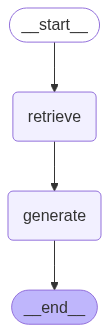

In [15]:
from IPython.display import Image, display

display(Image(rag_graph.get_graph().draw_mermaid_png()))

## Test the RAG System

Let's test our RAG system with some sample questions about TechMart products.

In [16]:
def ask_question(question: str):
    """Helper function to ask a question to our RAG system."""
    print(f"\nQuestion: {question}")
    print("=" * 60)
    
    # Run the RAG workflow
    result = rag_graph.invoke({"question": question})
    
    print(f"\nAnswer: {result['answer']}")
    print("=" * 60)

In [27]:
# Test question 1: FAQ Enquiry
ask_question("How long does it take it take to ship to the US?")


Question: How long does it take it take to ship to the US?
Retrieved 5 documents for: 'How long does it take it take to ship to the US?'
  Doc 1 [techmart_faq.csv]: question: How long does standard shipping take within the continental US? | answer: Standard shippin...
  Doc 2 [techmart_faq.csv]: question: Which countries do you ship to? | answer: TechMart currently ships to the US, Canada, the ...
  Doc 3 [techmart_faq.csv]: question: How much does international shipping cost? | answer: International shipping starts at USD ...
  Doc 4 [techmart_faq.csv]: question: Will I have to pay customs duties? | answer: Orders shipped outside the US may be subject ...
  Doc 5 [techmart_faq.csv]: question: What happens if my package is lost in transit? | answer: If your tracking hasn’t updated f...

Answer: Standard shipping within the continental US typically arrives in 3–5 business days once your order has left our warehouse. If you need your order sooner or have specific delivery requirements, 

In [28]:
# Test question 2: Specific product inquiry
ask_question("What are the specs of the UltraBook Pro 14?")


Question: What are the specs of the UltraBook Pro 14?
Retrieved 5 documents for: 'What are the specs of the UltraBook Pro 14?'
  Doc 1 [techmart_catalog.csv]: product_id: SKU001 | name: UltraBook Pro 14 Laptop | category: Laptop | price: 1499.0 | short_desc: ...
  Doc 2 [techmart_catalog.csv]: product_id: SKU164 | name: ZenithBook Air 13 | category: Laptop | price: 1199.0 | short_desc: Ultra-...
  Doc 3 [techmart_catalog.csv]: product_id: SKU232 | name: ZenithBook 11 Evo | category: Laptop | price: 1299.0 | short_desc: A slee...
  Doc 4 [techmart_catalog.csv]: product_id: SKU057 | name: ZenithBook 13 Evo | category: Laptop | price: 1299.0 | short_desc: Sleek ...
  Doc 5 [techmart_catalog.csv]: product_id: SKU053 | name: ZenithBook Air 15 | category: Laptop | price: 1299.0 | short_desc: Sleek ...

Answer: Here are the specifications of the UltraBook Pro 14 Laptop:

- **Processor (CPU):** Intel Core i7‑1370P (13th generation)
- **RAM:** 16 GB LPDDR5
- **Storage:** 512 GB SSD
- **Display

In [29]:
# Test question 3: Technical support question
ask_question("My wireless mouse keeps disconnecting")


Question: My wireless mouse keeps disconnecting
Retrieved 5 documents for: 'My wireless mouse keeps disconnecting'
  Doc 1 [techmart_troubleshooting.csv]: issue_title: Wireless mouse disconnects randomly | product_id: SKU010 | symptoms: Cursor freezes for...
  Doc 2 [techmart_troubleshooting.csv]: issue_title: Mouse Pointer Lag or Stuttering in Wireless Mode | product_id: SKU035 | symptoms: When ...
  Doc 3 [techmart_troubleshooting.csv]: issue_title: Mouse Pointer Lagging or Stuttering During Use | product_id: SKU236 | symptoms: While m...
  Doc 4 [techmart_troubleshooting.csv]: issue_title: Mouse Pointer Lag or Stuttering During Use | product_id: SKU102 | symptoms: While using...
  Doc 5 [techmart_troubleshooting.csv]: issue_title: Mouse cursor movement is erratic or jittery | product_id: SKU186 | symptoms: When using...

Answer: I'm sorry to hear your wireless mouse keeps disconnecting. Based on the information from TechMart’s troubleshooting guide, here are some steps you can try 

## Try it out!

Now you can ask your own questions! Try asking about:
- Product recommendations
- Technical specifications
- Troubleshooting issues
- Product comparisons

In [30]:
# Ask your own question here!
your_question = "What is the warranty on the nanowave ssd?"
ask_question(your_question)


Question: What is the warranty on the nanowave ssd?
Retrieved 5 documents for: 'What is the warranty on the nanowave ssd?'
  Doc 1 [techmart_catalog.csv]: product_id: SKU126 | name: NanoVault X8 NVMe SSD | category: Storage | price: 179.99 | short_desc: H...
  Doc 2 [techmart_faq.csv]: question: How long is the warranty on laptops? | answer: All TechMart laptops carry a 1‑year limited...
  Doc 3 [techmart_faq.csv]: question: Are batteries covered under warranty? | answer: Rechargeable batteries are warranted for o...
  Doc 4 [techmart_catalog.csv]: product_id: SKU297 | name: FlashCore X5 NVMe SSD | category: Storage | price: 179.99 | short_desc: H...
  Doc 5 [techmart_catalog.csv]: product_id: SKU147 | name: RapidStor NVMe X5 SSD | category: Storage | price: 179.99 | short_desc: H...

Answer: Based on the provided context, there is no information about a "nanowave ssd" in the TechMart catalog. If you are referring to the NanoVault X8 NVMe SSD, it comes with a 5-year warranty. If you m

## Limitations of Basic RAG

While our basic RAG system works well for simple questions, it has some limitations. Right now, all our documents are ingested into a single vector db index.

Let's explore what happens when we ask questions that span multiple domains or have ambiguous intent.

### Our Data

Our TechMart database contains three distinct types of information:

1. **Product Catalog** (~532 products): Detailed specs and descriptions of laptops, desktops, monitors, and audio equipment
2. **FAQ** (~51 Q&As): Customer service information about shipping, delivery, returns, and policies  
3. **Troubleshooting** (~1115 issues): Technical problems and step-by-step solutions for specific products

### The Problems

The current system faces several challenges:

#### 1. Context Confusion Within Static Data
- **Context confusion**: Mixing product specs with shipping policies
- **Intent ambiguity**: Keywords that mean different things in different domains
- **Irrelevant context**: Wrong document types polluting the answer

#### 2. Outdated Information Limitations
Our vector database only contains static, pre-ingested information, which creates significant gaps:
- **Stale troubleshooting**: Software issues and bug fixes change rapidly - our stored solutions may be outdated
- **Missing latest updates**: New driver versions, firmware updates, or compatibility patches aren't reflected
- **Generic limitations**: For complex technical issues, we might need current community forums, official documentation, or vendor support pages

#### 3. Multi-Source Intelligence Challenges
As we expand beyond our internal knowledge base to include real-time information sources, new complexities emerge:
- **Source selection**: Determining whether to query internal docs, search the web, or check vendor APIs
- **Information routing**: Knowing when a customer needs product specs (internal) vs. latest driver updates (external)
- **Context prioritization**: Balancing comprehensive internal knowledge with fresh external information

Let's see these limitations in action with some problematic questions.

## Problematic Questions

Let's test our basic RAG system with questions that expose its limitations. Notice how these questions retrieve mixed or inappropriate context.

### Question 1: Multi-Domain Query

In [31]:
# This question spans both product selection AND shipping policy
ask_question("Do you have bluetooth headphones and how fast can they be shipped within the US?")


Question: Do you have bluetooth headphones and how fast can they be shipped within the US?
Retrieved 5 documents for: 'Do you have bluetooth headphones and how fast can they be shipped within the US?'
  Doc 1 [techmart_faq.csv]: question: Do you offer next‑day delivery for laptops? | answer: Yes, we offer overnight delivery on ...
  Doc 2 [techmart_catalog.csv]: product_id: SKU309 | name: EchoPulse True Wireless Earbuds | category: Audio | price: 159.0 | short_...
  Doc 3 [techmart_catalog.csv]: product_id: SKU266 | name: EchoPulse True Wireless Earbuds | category: Audio | price: 129.0 | short_...
  Doc 4 [techmart_catalog.csv]: product_id: SKU008 | name: SoundWave ANC Headphones | category: Audio | price: 249.0 | short_desc: S...
  Doc 5 [techmart_catalog.csv]: product_id: SKU287 | name: EchoPulse True Wireless Earbuds | category: Audio | price: 129.0 | short_...

Answer: Yes, we do have Bluetooth headphones available. One option is the SoundWave ANC Headphones, which feature Bluetoo

### Question 2: Troubleshooting vs Product Info

In [55]:
# This should retrieve product info, but might get troubleshooting steps instead
ask_question("ultrabook pro charging ports")


Question: ultrabook pro charging ports
Retrieved 5 documents for: 'ultrabook pro charging ports'
  Doc 1 [techmart_troubleshooting.csv]: issue_title: ZenithBook Air 15 Not Charging When Plugged In via USB-C | product_id: SKU053 | symptom...
  Doc 2 [techmart_troubleshooting.csv]: issue_title: Laptop Does Not Charge When Plugged Into Thunderbolt 4 Port | product_id: SKU230 | symp...
  Doc 3 [techmart_troubleshooting.csv]: issue_title: Laptop Does Not Charge When Plugged Into USB-C Port | product_id: SKU050 | symptoms: Wh...
  Doc 4 [techmart_troubleshooting.csv]: issue_title: Laptop Not Charging When Connected to USB-C Power Adapter | product_id: SKU177 | sympto...
  Doc 5 [techmart_troubleshooting.csv]: issue_title: ZenithBook 15 Evo Not Charging When Plugged In via Thunderbolt 4 | product_id: SKU050 |...

Answer: Based on the provided context, there is no specific troubleshooting or technical information available regarding the charging ports of the "Ultrabook Pro" model. The context

### Question 4: Policy vs Product Confusion

In [36]:
# Should focus on return/warranty policy, but might get monitor specs / you can see noisy documents below
ask_question("What's your return policy for monitors?")


Question: What's your return policy for monitors?
Retrieved 5 documents for: 'What's your return policy for monitors?'
  Doc 1 [techmart_faq.csv]: question: What is your return window? | answer: Most products can be returned in like‑new condition ...
  Doc 2 [techmart_catalog.csv]: product_id: SKU007 | name: VisionView 24 FHD Monitor | category: Monitor | price: 179.0 | short_desc...
  Doc 3 [techmart_catalog.csv]: product_id: SKU006 | name: VisionView 34 Ultrawide Monitor | category: Monitor | price: 699.0 | shor...
  Doc 4 [techmart_faq.csv]: question: What if I receive a damaged product? | answer: Please email photos of the damage within 48...
  Doc 5 [techmart_catalog.csv]: product_id: SKU312 | name: PixelFusion 32 QHD Monitor | category: Monitor | price: 379.0 | short_des...

Answer: Our return policy for monitors is as follows: Most products, including monitors, can be returned in like‑new condition within 30 days of delivery for a full refund. If you receive a damaged monitor, 

### Question 5: Multi-hop query

In [37]:
# Need to look at product specs for both, but only retrieves the specs for zenithbook
ask_question("battery life for zenithbook air 15 vs ultrapook 14 pro")


Question: battery life for zenithbook air 15 vs ultrapook 14 pro
Retrieved 5 documents for: 'battery life for zenithbook air 15 vs ultrapook 14 pro'
  Doc 1 [techmart_catalog.csv]: product_id: SKU053 | name: ZenithBook Air 15 | category: Laptop | price: 1299.0 | short_desc: Sleek ...
  Doc 2 [techmart_catalog.csv]: product_id: SKU164 | name: ZenithBook Air 13 | category: Laptop | price: 1199.0 | short_desc: Ultra-...
  Doc 3 [techmart_catalog.csv]: product_id: SKU050 | name: ZenithBook 15 Evo | category: Laptop | price: 1299.0 | short_desc: 15.6" ...
  Doc 4 [techmart_catalog.csv]: product_id: SKU177 | name: ZenithBook 12 Evo | category: Laptop | price: 1299.0 | short_desc: 15.6" ...
  Doc 5 [techmart_catalog.csv]: product_id: SKU057 | name: ZenithBook 13 Evo | category: Laptop | price: 1299.0 | short_desc: Sleek ...

Answer: Based on the provided context, here is the battery life information:

- **ZenithBook Air 15**: Up to **12 hours** of battery life.
- **Ultrapook 14 Pro**: There 

### Question 6: Lack of information


In [41]:
# This query requires current OS error information not in our TechMart database
ask_question("How do I fix Windows 11 blue screen error 0x0000007E?")


Question: How do I fix Windows 11 blue screen error 0x0000007E?
Retrieved 5 documents for: 'How do I fix Windows 11 blue screen error 0x0000007E?'
  Doc 1 [techmart_troubleshooting.csv]: issue_title: DataVault SSD not recognized by Windows | product_id: SKU020 | symptoms: Drive letter m...
  Doc 2 [techmart_troubleshooting.csv]: issue_title: UltraBook Air Wi‑Fi disconnects frequently | product_id: SKU002 | symptoms: Wi‑Fi icon ...
  Doc 3 [techmart_troubleshooting.csv]: issue_title: Thunderbolt 4 Ports Not Detecting External Displays | product_id: SKU208 | symptoms: Wh...
  Doc 4 [techmart_troubleshooting.csv]: issue_title: No Display Output via HDMI 2.1 Port | product_id: SKU208 | symptoms: When connecting th...
  Doc 5 [techmart_troubleshooting.csv]: issue_title: CoreStation X5 Desktop Fails to Boot (Fans Spin, No Display) | product_id: SKU294 | sym...

Answer: The provided context does not contain specific troubleshooting steps for resolving the Windows 11 blue screen error 0x00000

### Question 7: Stale / limited information


In [ ]:
# This query requires current hardware information not in our database
ask_question("Whats the latest Nvidia GPU series for gaming?")


Question: Whats the latest Nvidia GPU series for gaming?
Retrieved 5 documents for: 'Whats the latest Nvidia GPU series for gaming?'
  Doc 1 [techmart_catalog.csv]: product_id: SKU068 | name: CoreStation S5 Tower Desktop | category: Desktop | price: 1249.0 | short_...
  Doc 2 [techmart_catalog.csv]: product_id: SKU080 | name: PowerForge S5 Desktop | category: Desktop | price: 1399.0 | short_desc: M...
  Doc 3 [techmart_catalog.csv]: product_id: SKU277 | name: CoreStation X5 Desktop | category: Desktop | price: 1299.0 | short_desc: ...
  Doc 4 [techmart_catalog.csv]: product_id: SKU224 | name: PowerEdge Fusion X5 Desktop | category: Desktop | price: 1599.0 | short_d...
  Doc 5 [techmart_catalog.csv]: product_id: SKU134 | name: CoreStation S5 Desktop | category: Desktop | price: 1299.0 | short_desc: ...

Answer: Based on the provided context, the latest Nvidia GPU series featured in TechMart's current desktop lineup is the NVIDIA GeForce RTX 4060. All the listed gaming and creator deskt

We will see how to solve these limitations in the next exercises!